<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-and-some-probability-functions" data-toc-modified-id="import-and-some-probability-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import and some probability functions</a></span></li><li><span><a href="#generate-synthetic-data" data-toc-modified-id="generate-synthetic-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>generate synthetic data</a></span></li><li><span><a href="#functions-for-inference" data-toc-modified-id="functions-for-inference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>functions for inference</a></span></li><li><span><a href="#train" data-toc-modified-id="train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>train</a></span></li><li><span><a href="#examine-model-performance" data-toc-modified-id="examine-model-performance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>examine model performance</a></span></li><li><span><a href="#accuracy" data-toc-modified-id="accuracy-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>accuracy</a></span></li></ul></div>

# import and some probability functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib as mpl
from tqdm.notebook import tqdm,trange
# import pdb
import inspect
import scipy.io
import copy

import scipy.stats, scipy.special
from scipy.special import digamma as Digamma
from scipy.special import gamma as Gamma

from numpy.random import gamma as Gammar
from numpy.random import beta as Beta
from numpy.random import multivariate_normal as Normal

from PIL import Image
import pandas as pd

In [2]:
def GammaR(alpha, beta):
    return Gammar(alpha, scale = 1/beta)

In [3]:
def log(x):
    return np.log(x)

In [4]:
def logGamma(x):
    return np.log(Gamma(x))

In [5]:
def stirling(x):
    return np.sqrt(2*np.pi/x)*(x/np.e)**x

In [6]:
def IBP(alpha = 10, num_object = 20):
    n_init = np.random.poisson(alpha)
    Z = np.zeros(shape=(num_object,n_init),dtype = np.int32)
    Z[0,:] = 1
    K_plus = n_init
    for i in range(1,num_object):
        # Calculate probability of visiting past dishes
        Z[i,:] = Z.sum(axis = 0)/(i+1) > np.random.rand(1,K_plus)
        # Calculate the number of new dishes visited by customer i
        K_new = np.random.poisson(alpha/(i+1)) 
        Z=np.concatenate((Z,np.zeros(shape=(num_object,K_new),dtype = np.int32)), axis=1)
        Z[i,K_plus:K_plus+K_new] = 1
        # Update matrix size and dish popularity count
        K_plus = K_plus+K_new
    return Z, K_plus

# generate synthetic data

In [7]:
A = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])
def gen_data(A, sigma_x = 0.5, num_object = 100):
    num_feature, num_dim = A.shape
    I = sigma_x*np.ones(num_dim)
    Z = np.zeros((num_object, num_feature))
    X = np.zeros((num_object, num_dim))
    for i in range(num_object):
        while (Z[i,:].sum() == 0):
            Z[i,:] = np.random.rand(1,num_feature) > .5
        X[i,:] = np.random.randn(num_dim)*I+Z[i,:]@A
    return X, Z

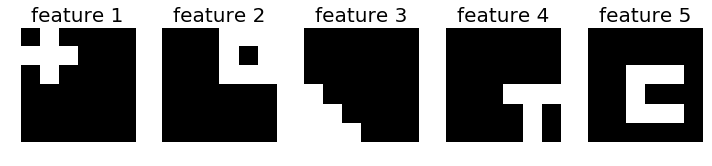

In [8]:
# show predetermined features
fig, ax = plt.subplots(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,1+i)
    plt.imshow(A[i,:].reshape(6,6), cmap='gray')
    plt.axis('off')
    plt.title(f'feature {i+1}', fontsize= 20)
plt.tight_layout()
plt.show()


In [9]:
# hyperparameters for generating data
sigma_x = 0.2
num_feature = 5
num_dim = 36
num_object = 200
X,Z_groundtruth = gen_data(A, sigma_x = sigma_x, num_object = num_object)

In [269]:
# do not need to normalize
# X = X - X.min()+0.001
# X = X/X.max()

In [238]:
# save image and true label
# np.savetxt('Z.txt', Z_groundtruth)
# from pathlib import Path
# Path("./results").mkdir(parents=True, exist_ok=True)
# for i in range(num_object):
#     plt.imsave('./results/'+str(i)+'.jpg', X[i,:].reshape(6,6), cmap='gray')

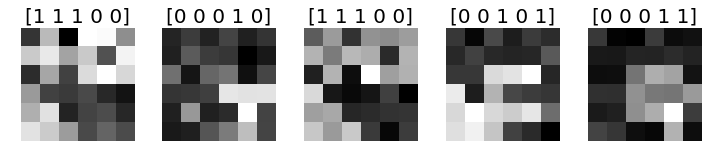

In [10]:
# show first 5 examples
plt.figure(figsize = (10,5.5))
# plt.suptitle('Sample from dataset', fontsize = 18)
for i in range(5):
#     print(Z_groundtruth[i])
    plt.subplot(1,5,1+i)
    plt.title(f'{str(Z_groundtruth[i].astype(int))}', fontsize = 20)
    plt.axis('off')
    plt.imshow(X[i,:].reshape(6,6), cmap='gray')
plt.tight_layout()
plt.show()

# functions for inference

In [11]:
# helper class for simpler function arguments and data storage
class params_set():
    def attrs_dict(self, exclude = []):
        dic = copy.deepcopy(self.__dict__)
        for key in exclude:
            del dic[key]
        return dic
    def print_attrs(self, key = None):
        if key == None:
            key = list(self.attrs_dict().keys())
        for k in key:
            print(k+": ",self.attrs_dict()[k])
    def set_attrs_dict(self, dic): 
#         self.__dict__ = dic
        for k,v in dic.items():
            self.__dict__[k] = v

In [12]:
def compute_auxiliary_q_and_lb(eta, k):
    eta = eta[:k,:]
    temp = Digamma(eta[:,1]) \
         + np.cumsum(np.insert(Digamma(eta[:,0]),0,0))[:-1] \
         - np.cumsum(Digamma(eta[:,0]+eta[:,1])) 
    q = np.exp(temp-temp.max())
    q = q/q.sum()
    lb = (q*(temp - log(q))).sum()
    return q, lb   

In [13]:
def compute_lower_bound(X, model):
    # following section 2.2 in VIBP derivation (eq.10)
    N = model.N
    K = model.K
    D = model.D
    
    alpha_0 = model.alpha_0
    tau_A0 = model.tau_A0
    tau_n0 = model.tau_n0
    
    rho_alpha = model.rho_alpha
    rho_A = model.rho_A
    rho_n = model.rho_n
    nu = model.nu
    eta = model.eta
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    
    terms = [] # save terms seperately for debugging purpose
    
    # first three terms (eq.17), for alpha, tau_A, and tau_n
    term1 = alpha_0[1]**alpha_0[0]/Gamma(alpha_0[0]) \
            + (alpha_0[0] - 1)*(-log(rho_alpha[1]) + Digamma(rho_alpha[0])) \
            - alpha_0[0]*rho_alpha[0]/rho_alpha[1]
    terms.append(term1)
    
    term2 = tau_A0[1]**tau_A0[0]/Gamma(tau_A0[0]) \
            + (tau_A0[0] - 1)*(-log(rho_A[1]) + Digamma(rho_A[0])) \
            - tau_A0[0]*rho_A[0]/rho_A[1]
    terms.append(term2)
    
    term3 = tau_n0[1]**tau_n0[0]/Gamma(tau_n0[0]) \
            + (tau_n0[0] - 1)*(-log(rho_n[1]) + Digamma(rho_n[0])) \
            - tau_n0[0]*rho_n[0]/rho_n[1]
    terms.append(term3)
    
    # forth term (eq.18), for v
    term4 = K*(-log(rho_alpha[1]) + Digamma(rho_alpha[0])) \
            + (rho_alpha[0]/rho_alpha[1] - 1) \
                *(Digamma(eta[:,0]) - Digamma(eta.sum(axis=1))).sum()
    terms.append(term4)
    
    # fifth term (eq.19), for Z
    term5 = 0
    for k in range(K):
        q, lb = compute_auxiliary_q_and_lb(eta, k+1)
        term5 += nu[:,k].sum()*(Digamma(eta[:k+1,0]) - Digamma(eta[:k+1,0]+eta[:k+1,1])).sum() \
                + (N-nu[:,k].sum())*lb
    terms.append(term5)
    
    # sixth term (eq.24), for A
    term6 = K*D/2*(-log(rho_A[1]) + Digamma(rho_A[0])-log(2*np.pi)) \
            - rho_A[0]/2/rho_A[1] * (phi_cov.sum() + (phi_mean**2).sum()) # need to confirm the last term (phi_mean**2).sum()
    terms.append(term6)
    
    # seventh term (eq.26), for likelihood
    term7 = N*D/2*(-log(rho_n[1]) + Digamma(rho_n[0]) - log(2*np.pi)) \
            - rho_n[0]/2/rho_n[1]*( (X**2).sum() \
                                   - 2*(nu*(X@phi_mean.T)).sum() \
                                   + ((nu@phi_mean)**2).sum() - (nu**2@phi_mean**2).sum() \
                                   + (nu*(np.ones_like(X)@(phi_cov + phi_mean**2).T)).sum() )  # need to confirm the last term (nu@(phi_cov + (phi_mean**2))).sum()
    terms.append(term7)
    
    # eighth term (eq.29), for entropy
    term8_1 = log(Gamma(rho_alpha[0])/(rho_alpha[1])**rho_alpha[0]) \
            - (rho_alpha[0] - 1)*(-log(rho_alpha[1]) + Digamma(rho_alpha[0])) \
            + rho_alpha[0]
    
    # approxiate term8_2 using Stirling's approximation
    temp = log(np.sqrt(2*np.pi/rho_A[0])) + rho_A[0] * log(rho_A[0]/np.e/rho_A[1])
#     term8_2 = log(Gamma(rho_A[0])/(rho_A[1])**rho_A[0]) \
    term8_2 = temp \
            - (rho_A[0] - 1)*(-log(rho_A[1]) + Digamma(rho_A[0])) \
            + rho_A[0]
    
    # approxiate term8_3 using Stirling's approximation
    temp = log(np.sqrt(2*np.pi/rho_n[0])) + rho_n[0] * log(rho_n[0]/np.e/rho_n[1])
#     term8_3 = log(Gamma(rho_n[0])/(rho_n[1])**rho_n[0]) \
    term8_3 = temp \
            - (rho_n[0] - 1)*(-log(rho_n[1]) + Digamma(rho_n[0])) \
            + rho_n[0]
    
    # approxiate term8_4 using Stirling's approximation
    temp = 0
    for i in range(eta.shape[0]):
        temp += log( np.sqrt(2*np.pi* (eta[i,0]+eta[i,1])/(eta[i,0]*eta[i,1]))) \
                + eta[i,0]*log(eta[i,0]) + eta[i,1]*log(eta[i,1]) \
                - (eta[i,0] + eta[i,1])*log(eta[i,0] + eta[i,1])
#     temp = logGamma(eta[:,0]).sum() + logGamma(eta[:,1]).sum() \
#             - logGamma(eta.sum(axis=1)).sum() \    
    term8_4 = temp \
            - ((eta[:,0] - 1)*Digamma(eta[:,0])).sum() \
            - ((eta[:,1] - 1)*Digamma(eta[:,1])).sum() \
            + ((eta.sum(axis=1) - 2)*Digamma(eta.sum(axis=1))).sum()
    
    term8_5 = K*D/2*log(2*np.pi*np.e) + 1/2*log(phi_cov).sum()
    
    tmp_nu = nu + 0.5*(nu==0) - 0.5*(nu==1)
    term8_6 = -tmp_nu*log(tmp_nu) - (1-tmp_nu)*log(1-tmp_nu)
    term8_6 = ( term8_6 * (nu>0) * (nu<1) ).sum() 
                                   
    term8s = np.array([term8_1, term8_2, term8_3, term8_4, term8_5, term8_6])
    term8 = term8s.sum()
    terms.append(term8)
                                   
    lower_bound = np.sum(terms)
    
    return lower_bound, terms

In [14]:
def update_phi(X, model):
    N = model.N
    K = model.K
    rho_A = model.rho_A
    rho_n = model.rho_n
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
   
    for k in range(K):
        non_k_idx = np.delete(np.arange(K), k)
        mat_B = (rho_A[0]/rho_A[1] + rho_n[0]/rho_n[1] * np.ones_like(X).T@nu[:,k]) # why the mask (ones_like in my case)?
        mat_C = X.T@nu[:,k]
        for n in range(N):
            mat_C -= nu[n,k] * (nu[n,non_k_idx].reshape(-1,1)*phi_mean[non_k_idx,:]).sum(axis = 0)
#         mat_C = mat_C * (rho_n[0]*nu[:,k].sum()/rho_n[1])
        mat_C = mat_C * (rho_n[0]/rho_n[1])
        
        phi_cov[k,:] = 1/mat_B
        phi_mean[k,:] = mat_C/mat_B
    return phi_mean, phi_cov


In [15]:
def update_nu(X, model):
    N = model.N
    K = model.K
    rho_n = model.rho_n
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    eta = model.eta
    
    for k in range(K):
        _, lb = compute_auxiliary_q_and_lb(eta, k+1)
        var_theta_k = (Digamma(eta[:k+1,0]) - Digamma(eta[:k+1,:].sum(axis=1))).sum() - lb
        non_k_idx = np.delete(np.arange(K), k)
        for n in range(N):
            var_theta = var_theta_k - (rho_n[0]/2/rho_n[1]) * ((phi_cov[k,:].sum() + (phi_mean[k,:]**2).sum()) \
                           - 2*(phi_mean[k,:].T@(X[n,:].T - (nu[n, non_k_idx].reshape(-1,1) * phi_mean[non_k_idx,:]).sum(axis=0) )) )
            nu[n,k] = max(0.00001, 1/(1+np.exp(-var_theta)) )  # var_theta can be too negative, lead to overflow
    return nu       
                                     

In [16]:
def update_eta(model):
    N = model.N
    K = model.K
    nu = model.nu
    eta = model.eta
    alpha_0 = model.alpha_0
    
    sum_n_nu = nu.sum(axis=0)
    N_minus_sum_n_nu = N - sum_n_nu
    for k in range(K):
        q,_ = compute_auxiliary_q_and_lb(eta, K)
        qs = np.zeros((K,K))
        for m in range(k,K):
            qs[m,:m+1] = q[:m+1]/q[:m+1].sum()
        eta[k,0] = alpha_0[0] + sum_n_nu[k:].sum() \
                        + N_minus_sum_n_nu[k+1:]@qs[k+1:,k+1:].sum(axis=1) # confirmed with doshi's
        eta[k,1] = N_minus_sum_n_nu[k:]@qs[k:,k] + 1   # confirmed with doshi's
    return eta
        

In [17]:
def update_rho_A(model):
    K = model.K
    D = model.D
    tau_A0 = model.tau_A0
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    rho_A = model.rho_A
    
    rho_A[0] = tau_A0[0] + D*K/2
    rho_A[1] = tau_A0[1] +1/2*(phi_cov.sum() + (phi_mean**2).sum())
    return rho_A

In [18]:
def update_rho_n(X, model):
    N = model.N
    K = model.K
    D = model.D
    tau_n0 = model.tau_n0
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    rho_n = model.rho_n

    rho_n[0] = tau_n0[0] + D*N/2
    
    # X**2 may too large
    rho_n[1] = tau_n0[1] \
             + 1/2*( (X**2).sum() \
             - 2*(nu*(X@phi_mean.T)).sum() \
             + ((nu@phi_mean)**2).sum() - (nu**2@phi_mean**2).sum() \
             + (nu*(np.ones_like(X)@(phi_cov + phi_mean**2).T)).sum() )  # links to term 7 in lower bound
    return rho_n

In [19]:
def update_rho_alpha(model):
    K = model.K
    alpha_0 = model.alpha_0
    eta = model.eta
    rho_alpha = model.rho_alpha
    
    rho_alpha[0] = alpha_0[0] + K
    rho_alpha[1] = alpha_0[1] \
                 - (Digamma(eta[:,0]) - Digamma(eta[:,0]+eta[:,1])).sum()
    return rho_alpha

In [25]:
def update_parameters(X, model, maxIter = 20, thresh = 1e-2):
    itr_count = 0
    lb, _ = compute_lower_bound(X, model)
    local_lbs = []
#     print('initial lb: ',lb)
    while 1:
#         print('='*20,'itr {}'.format(itr_count),'='*20)
        itr_count += 1
        for j in np.random.permutation(6): # update in random order
            if j == 0:
                eta = update_eta(model)
                model.eta = eta
            elif j == 1:
                nu = update_nu(X, model)
                model.nu = nu
            elif j == 2:
                phi_mean, phi_cov = update_phi(X, model)
                model.phi[0,:,:] = phi_mean
                model.phi[1,:,:] = phi_cov
            elif j == 3:
                rho_A = update_rho_A(model)
                model.rho_A = rho_A
            elif j == 4:
                rho_n = update_rho_n(X, model)
                model.rho_n = rho_n
            else:
                rho_alpha = update_rho_alpha(model)
                model.rho_alpha = rho_alpha
        lb, _ = compute_lower_bound(X, model)
#         print(lb)
        if (np.std(local_lbs[-3:]) < thresh and itr_count > 3) or itr_count >= maxIter:
            break
            
    return model

In [26]:
def move(model, h, l):
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    nu = model.nu
    
    r = np.random.randint(5)
    if r == 0:  # Let h = h - l, leave l alone
        phi_mean[h,:] = phi_mean[h,:] - phi_mean[l,:]
        nu[:,h] = nu[:,h] - nu[:,l]
        nu[nu[:,h] <= 0,h] = 0.0001  # make sure it's larger than 0
    elif r == 1: # Let h = h + l, leave l alone
        phi_mean[h,:] = phi_mean[h,:] + phi_mean[l,:]
        nu[:,h] = nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1,h] = 0.9999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 2: # Let h = h + l, delete l
        phi_mean[h,:] = phi_mean[h,:] + phi_mean[l,:]
        phi_mean[l,:] = 0.01*np.random.rand(phi_mean[l,:].shape[0])
        nu[:,h] = nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1,h] = 0.9999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 3: # randomly reset h and l
        phi_mean[h,:] = 0.01*np.random.randn(phi_mean[h,:].shape[0])
        phi_mean[l,:] = 0.01*np.random.randn(phi_mean[l,:].shape[0])
        nu[:,h] = np.random.rand(nu[:,h].shape[0])
        nu[:,l] = np.random.rand(nu[:,l].shape[0])
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 4: # h = h - l, l = h + l
        phi_mean[h,:], phi_mean[l,:] = phi_mean[h,:] - phi_mean[l,:], phi_mean[h,:] + phi_mean[l,:]
        nu[:,h], nu[:,l] = nu[:,h] + nu[:,l], nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1,h] = 0.9999 # make sure it's smaller than 1
        nu[nu[:,l] >= 1,l] = 0.9999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    model.phi[0,:,:] = phi_mean
    model.phi[1,:,:] = phi_cov
    model.nu = nu
    return model

In [27]:
def search_heuristics(X, model):
    best_lb, _ = compute_lower_bound(X, model)
    best_model_dic = model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])
    
    K = model.K
    
    for h in range(K):
        for l in np.delete(np.arange(K), h):
            new_model = copy.deepcopy(model)
            new_model = move(new_model, h, l)
            new_model = update_parameters(X, new_model, maxIter = 5)
            new_lb, _ = compute_lower_bound(X, new_model)
            if new_lb > best_lb:
                best_model_dic = new_model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])
                best_lb = new_lb
            new_model = None
    return best_lb, best_model_dic

In [28]:
def initialize_model(model, K = 6):
     # save model parameters
    model.N, model.D = X.shape
    model.K = K # set maximum truncation level

    # priors
    model.alpha_0 = np.array([1.1, 1.1])
    model.tau_A0 = np.array([1.1, 1.1])
    model.tau_n0 = np.array([1.1, 1.1])

    # variational parameters
    model.rho_alpha = np.random.rand(2)
    model.rho_A = np.random.rand(2)
    model.rho_n = np.random.rand(2)
    model.phi = np.random.rand(2, model.K, model.D) # Dim 0 for mean and dim 1 for var
                                                    # same in doshi's code, assume independent
    model.eta = np.random.rand(model.K, 2)
    model.nu = np.random.rand(model.N, model.K)
    return model

# train

In [30]:
model = params_set()
# for logging purpose
model.lbs = []
model.model_sets = []
model.best_lb = 0
# recording which iteration in which run has the best lb 
model.best_model_idx = (0,0) # (best run idx, best iter idx) 


for i in range(1):
    print('='*50)
    print('='*20,'Run #{}'.format(i),'='*20)
    print('='*50)
    
    model = initialize_model(model, 6)
    lb, _ = compute_lower_bound(X, model)
    print('initial lb: ', lb)
    
    lbs = [lb]
    model_sets = [model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])]
    iter_count = 0
    while 1:
        model = update_parameters(X, model, maxIter = 2)
        lb, _ = compute_lower_bound(X, model)
        print('after update_parameters, lb: ', lb)

        best_lb, best_model_dic = search_heuristics(X, model)
        model.set_attrs_dict(best_model_dic)
        lb, _ = compute_lower_bound(X, model)
        print('after search_heuristics, lb: ', lb)
        
        lbs.append(lb)
        model_sets.append(model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx']))
        if len(lbs) > 3 and np.std(lbs[-3:]) <1e-3:
            break
        if model.best_lb < lb or model.best_lb == 0:
            model.best_lb = lb
            model.best_model_idx = (i,iter_count)
        iter_count += 1
        
    model.model_sets.append(model_sets)
    model.lbs.append(lbs)


==================== Run #0 ====================
initial lb:  -37537.34815467718


/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


after update_parameters, lb:  -6406.840103054027
after search_heuristics, lb:  -2647.782827356279
after update_parameters, lb:  -2029.7523973333923
after search_heuristics, lb:  -33.72703729091896
after update_parameters, lb:  -7.470376259424096
after search_heuristics, lb:  23.91422964313966
after update_parameters, lb:  27.708694756513275
after search_heuristics, lb:  31.47882473503446
after update_parameters, lb:  34.81787764971734
after search_heuristics, lb:  41.44620036839581
after update_parameters, lb:  43.264421850724396
after search_heuristics, lb:  43.264421850724396
after update_parameters, lb:  43.99889268574448
after search_heuristics, lb:  43.99889268574448
after update_parameters, lb:  44.479893273509646
after search_heuristics, lb:  44.69497071760586
after update_parameters, lb:  44.96920559994459
after search_heuristics, lb:  44.96920559994459
after update_parameters, lb:  45.17277683235975
after search_heuristics, lb:  45.17277683235975
after update_parameters, lb:  

# examine model performance

In [32]:
best_model_idx = model.best_model_idx

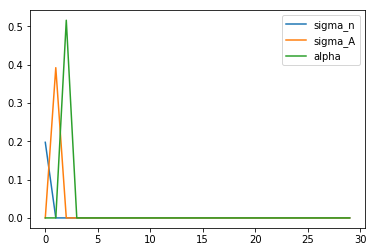

In [33]:
label_names = ['sigma_n', 'sigma_A', 'alpha']
model_sets = model.model_sets[best_model_idx[0]]
for i,name in enumerate(['rho_n', 'rho_A', 'rho_alpha']):
    parameters = np.zeros(len(model_sets))
    for j,model_set in enumerate(model_sets):
        parameters[i] = np.sqrt((model_sets[j][name][1])/(model_sets[j][name][0]))
    plt.plot(parameters, label = label_names[i])
plt.legend()
plt.show()

In [34]:
def plot_para_history(model_sets, name, title = None):
    plt.figure(figsize = (6,4))
    parameters = np.zeros(len(model_sets))
    for i,model_set in enumerate(model_sets):
        parameters[i] = np.sqrt((model_sets[i][name][1])/(model_sets[i][name][0]))
    plt.plot(parameters, label = str(i))
    if title:
        plt.ylabel(title,fontsize = 24)
    plt.xticks(fontsize = 14)
    plt.xlabel('iterations', fontsize = 16)
    plt.yticks(fontsize = 14)
    plt.show()

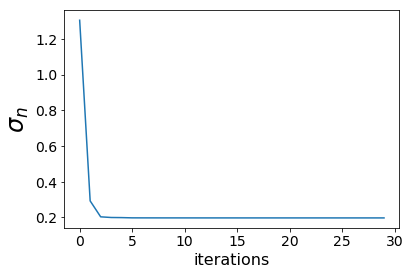

In [35]:
plot_para_history(model_sets, 'rho_n', title='$\sigma_n$')

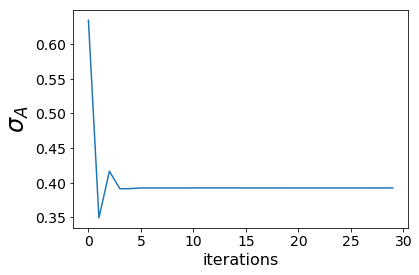

In [36]:
plot_para_history(model_sets, 'rho_A', title='$\sigma_A$')

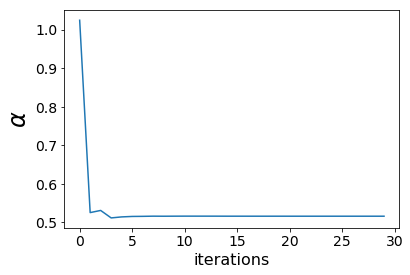

In [37]:
plot_para_history(model_sets, 'rho_alpha', title=r'$\alpha$')

In [38]:
best_model_idx = model.best_model_idx
best_model = model.model_sets[best_model_idx[0]][best_model_idx[1]]
print(best_model_idx)

(0, 27)


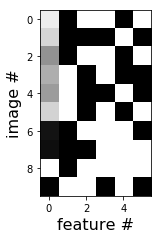

In [39]:
# show learned feature matrix Z
plt.figure(figsize = (2,5))
plt.imshow(best_model['nu'][:10,:], cmap='gray')
plt.xlabel('feature #', fontsize = 16)
plt.ylabel('image #', fontsize = 16)
plt.show()


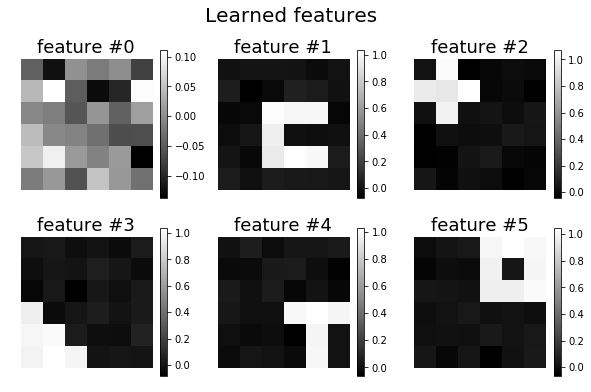

In [40]:
# show learned feature weight matrix A
plt.figure(figsize = (10,6))
plt.suptitle('Learned features', fontsize = 20)

for j in range(6):
    plt.subplot(2,3,1+j)
    plt.imshow(best_model['phi'][0,j,:].reshape(6,6), cmap = 'gray')
    plt.axis('off')
    plt.title(f'feature #{j}', fontsize = 18)
    plt.colorbar()
plt.show()

In [55]:
mapping = {1:4,2:0,3:2,4:3,5:1}

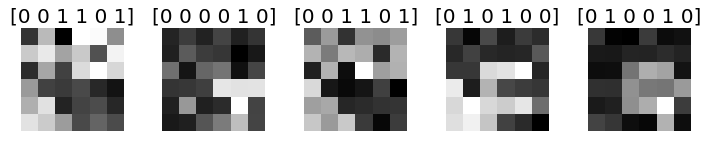

In [41]:
# show first 5 examples and there prediction
plt.figure(figsize = (10,5.5))
# plt.suptitle('Sample from dataset', fontsize = 18)
for i in range(5):
#     print(Z_groundtruth[i])
    plt.subplot(1,5,1+i)
    plt.title(f"{str(best_model['nu'][i,:].astype(int))}", fontsize = 20)
    plt.axis('off')
    plt.imshow(X[i,:].reshape(6,6), cmap='gray')
plt.tight_layout()
plt.show()

In [43]:
predicted_Z = best_model['nu'].astype(int)

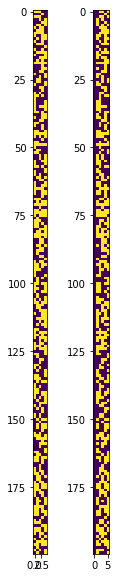

In [46]:
plt.figure(figsize=(2,10))
plt.subplot(1,2,1)
plt.imshow(Z_groundtruth)
plt.subplot(1,2,2)
plt.imshow(predicted_Z)
plt.show()

# accuracy

In [63]:
# per feature
p_sum = predicted_Z.sum(axis=0) 
t_sum = Z_groundtruth.sum(axis=0).astype(int)
p_sum_reordered = [0]*5
for k,v in mapping.items():
    p_sum_reordered[v] = p_sum[k]
print(p_sum_reordered)
print(t_sum)

[108, 96, 94, 102, 105]
[109  96  94 102 105]


In [64]:
for i in range(5):
    print(f'feature #{i}: {p_sum_reordered[i]}/{t_sum[i]} are corrected recognized')

feature #0: 108/109 are corrected recognized
feature #1: 96/96 are corrected recognized
feature #2: 94/94 are corrected recognized
feature #3: 102/102 are corrected recognized
feature #4: 105/105 are corrected recognized


In [65]:
# per instance
p_sum = predicted_Z.sum(axis=1) 
t_sum = Z_groundtruth.sum(axis=1)
(p_sum == t_sum).sum()/len(p_sum)

0.995